# Hands-on Lecture 1
## Implementation of RANSAC
- In this notebook, we will implement RANSAC (RANdom SAmple Consensus), an algorithm to calculate an affine transformation which is robust to outliers.

- The input and output in RANSAC is as follows:

**Input**:
$$
D = \{(\boldsymbol{x}_1, \boldsymbol{x}'_1), \cdots ,(\boldsymbol{x}_N, \boldsymbol{x}'_N) \}\\
\boldsymbol{x}_i = (x_i, y_i) \in \mathbb{Z}^2
$$

**Output**:
$$
H = \begin{pmatrix}
A & \boldsymbol{t} \\
\boldsymbol{0}^{\mathrm T} & 1\\
\end{pmatrix}
$$
where,
$$
A \in \mathbb{R}^{2 \times 2},\\
\boldsymbol{t} \in \mathbb{R}^{2 \times 1},\\
\boldsymbol{0}^{\mathrm T} = (0, 0) \in \mathbb{R}^{1 \times 2}
$$

- Let's break down the algorithm of RANSAC into several pieces and implement each of them.

### 0. Import necessary libraries

In [21]:
import numpy as np
import pylab
from PIL import Image
from random import choice
from scipy import hypot
from scipy.linalg import inv

from sift import match, read_features_from_file, plot_matches, plot_features
from ransac import get_points, get_homography
from homography import affine_transform2
%matplotlib inline

In [4]:
# set the seed 0
np.random.seed(0)

### 1. Select 3 samples randomly
- First of all, we will implement the function which selects 3 samples randomly.
- You can use **```choice```** function to obtain random samples

In [5]:
def select_three_samples(points_list):
    """
    Select 3 samples from points_list.
    
    Parameters
    ----------
    points_list: numpy array of feature pairs D = {(x_i, x'_i)}_{i=1}^N
    
    returns
    -------
    consensus_list: 3 samples randomly chosen from point_list
    points_list_temp: all the feature pairs other than the samples in consensus_list
    """
    points_list_temp = np.copy(points_list).tolist()
    consensus_list = []

    #### START HERE ####
    for _ in range(3):
        selected_sample = choice(points_list_temp)
        consensus_list.append(selected_sample)
        points_list_temp.remove(selected_sample)
    #### END HERE ####
    
    return consensus_list, points_list_temp

In [6]:
# test
# To Yang-san: please implement this.

### 2. Calculate affine transformation from these 3 samples
- Now we have collected 3 samples from ```points_list```.
- Let's calculate affine transformation $H$.

In [7]:
def affine_from_points(consensus_list):
    """
    Calculate affine transformation matrix H from consensus_list.
    
    Parameters
    ----------
    consensus_list: 3 samples chosen randomly.
    
    Returns
    -------
    H: the affine transformation.
    """
    
    # devide consensus_list and add the bias term
    fp = np.array([coordinate[0] + [1] for coordinate in consensus_list]).T
    tp = np.array([coordinate[1] + [1] for coordinate in consensus_list]).T
    if fp.shape != tp.shape:
        raise RuntimeError

    #condition points
    #-from points-
    m = np.mean(fp[:2], axis=1)
    maxstd = np.max(np.std(fp[:2], axis=1))
    C1 = np.diag([1/maxstd, 1/maxstd, 1])
    C1[0][2] = -m[0]/maxstd
    C1[1][2] = -m[1]/maxstd
    fp_cond = np.dot(C1,fp)

    #-to points-
    m = np.mean(tp[:2], axis=1)
    C2 = C1.copy() #must use same scaling for both point sets
    C2[0][2] = -m[0]/maxstd
    C2[1][2] = -m[1]/maxstd
    tp_cond = np.dot(C2,tp)

    #conditioned points have mean zero, so translation is zero
    A = np.concatenate((fp_cond[:2], tp_cond[:2]), axis=0)
    U,S,V = np.linalg.svd(A.T)

    #create B and C matrices as Hartley-Zisserman (2:nd ed) p 130.
    tmp = V[:2].T
    B = tmp[:2]
    C = tmp[2:4]

    tmp2 = np.concatenate((np.dot(C, np.linalg.pinv(B)), np.zeros((2,1))), axis=1)
    H = np.vstack((tmp2, [0,0,1]))

    #decondition
    H = np.dot(np.linalg.inv(C2), np.dot(H, C1))

    return H / H[2][2]
    
    return H

In [8]:
# test
# To Yang-san: please implement this.

### 3. Select points which do not contradict the affine transformation
- Now you have obtained the affine transformation $H$ using the 3 points randomly selected.
- Next, let's examine the other samples whether they contradict $H$ or not.
- Given the thereshold parameter $\theta$, you have to examine if the distance of each sample which is calculated as
$$d({\boldsymbol x}', H{\boldsymbol x}) = \sqrt{(\boldsymbol{x}' - H\boldsymbol{x})^T(\boldsymbol{x}' - H\boldsymbol{x})}$$
is within $\theta$ or not
- Store samples which do not contradict $H$ into **```consensus_set```**.
- You can use **```np.hypot```** function to calculate the l2 distance.

In [9]:
def select_samples_within_threshold(points_list_temp, consensus_list,\
                                    H, theta=10):
    """
    Select the sapmles whose error from the projection by H is less than theta.
    
    Parameters
    ----------
    point_list_temp: list of all the points except for the 3 points selected before.
    consensus_list: the 3 points.
    H: the affine transformation.
    theta: threshold value.
    
    Returns
    -------
    updated_consensus_list: list of all the points whose error from the projection by H is within theta.
    """
    
    updated_consensus_list = consensus_list[:]
    for p in points_list_temp:
        x1, y1 = p[0]
        x2, y2 = p[1]
        
        # reshape and add the bias term
        A = np.array([x1, y1, 1]).reshape(3,1)
        B = np.array([x2, y2, 1]).reshape(3,1)
        
        #### START HERE ####
        out = B - np.dot(H, A) # calculate the difference between B and HA
        dist_err = hypot(out[0][0], out[1][0]) # calculate the distance 
        
        try:
            if dist_err < theta:
                updated_consensus_list.append(p) # add this sample into consensus_set
        except ValueError:
            print(dist_err)
            print(type(dist_err))
            print(dist_err.shape)
        #### END HERE ####
    return updated_consensus_list

In [10]:
# test
# To Yang-san: please implement this.

### 4. Recalculate affine transformation matrix by updated_consensus_list
- Now we have got updated ```consensus_list```.
- Let's recalculate $H$ if $N_{tmp} > N_{max}$.
    - $N_{tmp}$ indicates the number of samples in current ```consensus_list```.
    - $N_{max}$ signifies the maximum $N_{tmp}$ calculated thus far.
- Use **```affine_from_points```** implemented in section 2.

In [11]:
def recalculate_affine_transformation(updated_consensus_list, N_max, H_best):
    """
    Recalculate the affine transformation if N_tmp > N_max
    
    Parameters
    ----------
    updated_consensus_list: 
    N_max: 
    H_best: 
    Returns
    -------
    H_best: affine transformation.
    N_max: N_max
    """
    
    N_tmp = len(updated_consensus_list)
    if N_tmp > N_max:
        #### START HERE ####
        H_best = affine_from_points(updated_consensus_list)
        N_max = N_tmp
        #### END HERE ####
    return H_best, N_max

In [12]:
# test (may not be necessary)
# To Yang-san: please implement this.

### 5. Put them together
- Now we have implemented all the pieces that are necessary to implement RANSAC.
- Let's put them together and make them function as RANSAC.

In [13]:
def RANSAC(points_list, M=20, theta=10.):
    """
    Calculate affine transformation using RANSAC.
    
    Parameters
    ----------
    points_list: list of points = [[[x_1, y_1], [x'_1, y'_1]], ...].
    M: number of iterations.
    theta: threshold.
    
    Returns
    -------
    H_best: the best affine transformation.
    """
    # initialize N_max := 0, H_best := np.eye(3)
    N_max = 0    
    H_best = np.eye(3)
    # iterate M times
    for i in range(M):
        
        # 1. select 3 points randomly
        consensus_list, points_list_temp = select_three_samples(points_list)
        
        # 2. Calculate affine transformation from these 3 samples
        H = affine_from_points(consensus_list)
        
        # 3. Select points which do not contradict the affine transformation
        updated_consensus_list = select_samples_within_threshold(points_list_temp, consensus_list,\
                                                                 H, theta)
        
        # 4. Recalculate affine transformation matrix by updated_consensus_list
        H_best, N_max = recalculate_affine_transformation(updated_consensus_list,\
                                                          N_max, H_best)
    return H_best

In [14]:
# test
# To Yang-san: please implement this.

## Demo
- Congratulations! Now we have implemented RANSAC!
- Let's apply your RANSAC to the 2 images below!

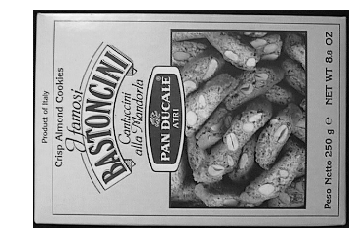

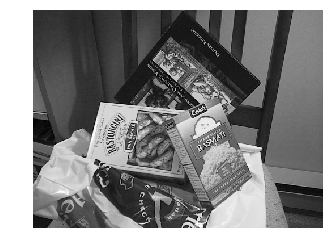

In [24]:
# load images
img_box = np.asarray(Image.open('box.pgm').convert('L'))
img_scene = np.asarray(Image.open('scene.pgm').convert('L'))

# Show images
for img in [img_box, img_scene]:
    pylab.gray()
    pylab.imshow(img, cmap='gray')
    pylab.axis('off')
    pylab.show()

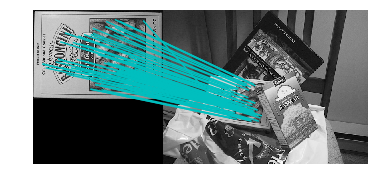

In [27]:
# load keypoints
key_box = read_features_from_file('box.key')
key_scene = read_features_from_file('scene.key')
score = match(key_box[1], key_scene[1])
points_list = get_points(key_box[0], key_scene[0], score)
plot_matches(img_box, img_scene, key_box[0], key_scene[0], score)
H = RANSAC(points_list, M=20, theta=10.)
H_ransac = inv(H)
H_simple = inv(get_homography(points_list))

img_ransac = affine_transform2(img_box,
                                H_ransac[:2, :2],
                                [H_ransac[0][2], H_ransac[1][2]])

img_simple = affine_transform2(img_box,
                                H_simple[:2, :2],
                                [H_simple[0][2], H_simple[1][2]])

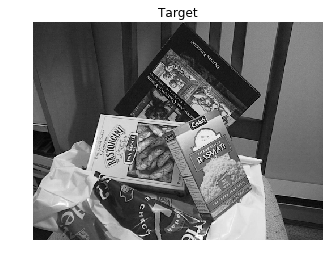

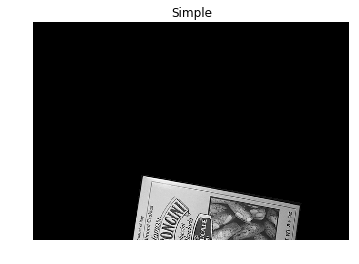

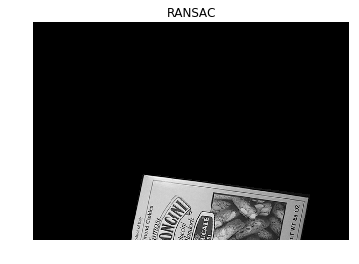

In [32]:
for name, img in zip(["Target", "Simple", "RANSAC"], [img_scene, img_simple, img_ransac]):
    pylab.gray()
    pylab.imshow(img, cmap='gray')
    pylab.axis('off')
    pylab.title(name)
    pylab.show()

## References
- https://github.com/vishwa91/pyimreg
- http://www.cs.ubc.ca/~lowe/keypoints/